In [ ]:
using GpABC, DifferentialEquations, Distances, Plots, Distributions

# Performing the Linear Noise Approximation and conducting ABC

This notebook will guide the user through not only performing the linear noise approximation (LNA) on any system the user wishes to but will also guide the user through then using the LNA when conducting ABC for parameter estimation.

## What is the LNA? 

The below shall be a brief overview of the definition of the LNA implemented in `GpABC`, if it is incomprehensible then the rest of then notebook should guide the user through the concept of the LNA. 

Still, it is important to mathematically outline the LNA.

The LNA approximates the Chemical Master Equation (CME) by decomposing the stochastic process into two ordinary differential equations (ODEs); one describing the evolution of the mean of the trajectories and the other describing the evolution of the covaraince of the trajectories.

In other words the LNA approximates the stochastic process by looking at the mean and the covariance of the trajectories $\textbf{x}(t)$, whose evolution is described by a system of ODEs which can be seen below:

$$
\begin{align}
\frac{d\varphi}{dt}&=\mathcal{S}\textbf{f}(\boldsymbol\varphi) \label{mean} \\ 
\frac{d\Sigma}{dt}&=\mathcal{A} \, \Sigma + \Sigma \, \mathcal{A}^T + \frac{1}{\sqrt{\Omega}} \, \mathcal{S} \, \text{diag}(\textbf{f}(\boldsymbol\varphi)) \, \mathcal{S}^T \label{covar}
\end{align}
$$

Here $\mathcal{S}$ is the stoichometry matrix of the system, $\textbf{f}$ is the reaction rates. 

The matrix $\mathcal{A}(t) = \mathcal{S}\mathcal{D}$ and $\mathcal{D}$ is the Jacobian of the reaction rates: $\{\mathcal{D} \}_{i,k} = \frac{\partial f_i(\boldsymbol\varphi)}{\partial \phi_k}$

These can be solved by numerical methods to describe how $\boldsymbol\varphi$ (the mean) and $\Sigma$ (the covariance) evolve with time.

The rest of the notebook should lead the user through this.

## Stochastic Three Gene Toy Example

The Three Gene Example is taken from Guy Karlebach and Ron Shamir "Modelling and analysis of gene regulatory networks" $\textit{Nature Reviews Molecular Cell Biology}$ (2008).

Consider a Three Gene Example where Gene 1, 2 and 3 are represented by $g_1$, $g_2$ and $g_3$ respectively and $\textbf{g} = (g_1, g_2, g_3)^T$. The kinetic parameters of the system are represented through $k_*$. Imagine a system where the concentrations of these genes vary and depend on each other and they are determined by the equations below: 

$$
\begin{align*} 
\emptyset & \overset{\hphantom{k_{1}} \, k_{1,s} \, g_3 \hphantom{k}}{\longrightarrow}   g_1  \\ 
g_1 & \overset{\hphantom{k_{1,s}} \, k_{1,d} \,  \hphantom{k_{1,s}}}{\longrightarrow} \emptyset \\ 
g_1 & \overset{ \hphantom{k_{1}} \,k_{2,s} \, g_1 \hphantom{k_{1,s}}}{\longrightarrow} g_1 + g_2 \\ 
g_2 & \overset{\hphantom{k_{1,s}}\, k_{2,d} \, \hphantom{k_{1,s}}}{\longrightarrow} \emptyset \\ 
g_1 + g_2 & \overset{k_{3,s} \, k_{3,1} \, k_{3,2} }{\longrightarrow} g_1 + g_2 + g_3 \\ 
g_3 & \overset{ \hphantom{k_{1,s}} \, k_{3,d} \, \hphantom{k_{1,s}}}{\longrightarrow}  \emptyset 
\end{align*}
$$

This can be pictorally understood through the diagram below. The interactions between the genes can be seen: Gene 1 activates Gene 2 and Gene 3, Gene 2 activates Gene 3 and finally gene 3 represses Gene 1.  

<img src="threegeneinteractions.png" width="500" height="1000">

What cannot be seen in the diagram is the degradation of all the genes and the activation of Gene 1 from a constant source. The above is adapted from Guy Karlebach and Ron Shamir "Modelling and analysis of gene regulatory networks" $\textit{Nature Reviews Molecular Cell Biology}$ (2008).

The reaction rates of this model is: 

 $\textbf{f}= \begin{bmatrix}
      \frac{ k_{1,s}}{1+k_{1,3} \, \textbf{g}_3}, & k_{1,d} \, \textbf{g}_1, & \frac{k_{2,s} \, k_{2,1}\, \textbf{g}_1}{1+k_{2,1} \, \textbf{g}_1}, & k_{2,d} \, \textbf{g}_2, & \frac{k_{3,s} \, k_{3,1} \, \textbf{g}_1 \,  k_{3,2} \, \textbf{g}_2}{(1+k_{3,1} \, \textbf{g}_1)(1+k_{3,2} \, \textbf{g}_2)}, & k_{3,d} \, \textbf{g}_3        
     \end{bmatrix} ^T$. 


The Stoichiometry matrix of the system is:

$$\mathcal{S} =
 \begin{pmatrix}
  1 & -1 & 0 & 0 & 0 & 0 \\
  0 & 0 & 1 & -1 & 0 & 0 \\
  0 & 0 & 0 & 0 & 1 & -1  
 \end{pmatrix} $$ and the reaction rates are 
 

    
The user requires $\mathcal{S}$ and $\textbf{f}$ when constructing a stochastic model of a system.

In this example, the parameters $[k_{1,s}, k_{2,s}, k_{3,s}, k_{1,d}, k_{1,d}, k_{2,d}, k_{3,d}, k_{1,3}, k_{2,1}, k_{3,1}, k_{3,1}]$ have been chosen to take values $[2.0, 1.0, 15.0, 1.0, 1.0, 1.0, 100.0, 1.0, 1.0, 1.0]$ 

So lets contruct $\mathcal{S}$ and $\textbf{f}$:

In [ ]:
S = [1.0 -1.0 0.0 0.0 0.0 0.0;  # stoichometry matrix 
     0.0 0.0 1.0 -1.0 0.0 0.0;
     0.0 0.0 0.0 0.0 1.0 -1.0]

params = [2.0, 1.0, 15.0, 1.0, 1.0, 1.0, 100.0, 1.0, 1.0, 1.0] #parameters

reaction_rate_function = function(x,params)
    f = [params[1]/(1+params[7]*x[3]),
        params[4]*x[1],
        params[2]*params[8]*x[1]/(1+params[8]*x[1]),
        params[5]*x[2],
        params[3]*params[9]*x[1]*params[10]*x[2]/(1+params[9]*x[1])/(1+params[10]*x[2]),
        params[6]*x[3]]
    return f
end

(::#1) (generic function with 1 method)

Notice how the reaction rates must be provided as a function.

The original ODE model by the relationship $\dot{\textbf{g}} = \mathcal{S} \, \textbf{f} $.

An example of this can be seen below. Notice how in `GeneReg` the only thing defining the ODE is:

$\mathcal{S} \, \textbf{f}$ .

The initial conditions, timspan, solver and saveat are arbitrary.

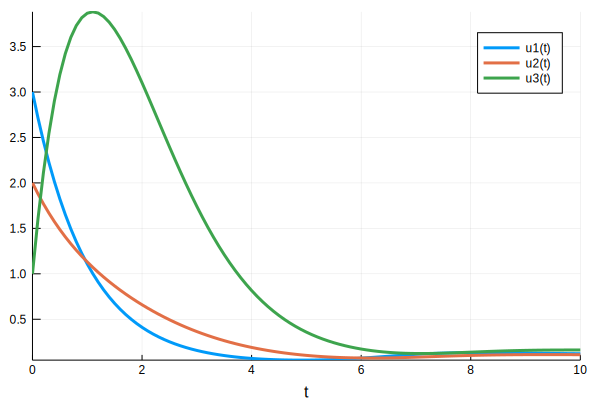

In [3]:
GeneReg = function(params::AbstractArray{Float64,1},
    Tspan::Tuple{Float64,Float64}, x0::AbstractArray{Float64,1},
    solver::OrdinaryDiffEq.OrdinaryDiffEqAlgorithm, saveat::Float64)

  if size(params,1) != 10
    throw(ArgumentError("GeneReg needs 10 parameters, $(size(params,1)) were provided"))
  end

  function ODE_3GeneReg(dx, x, par, t)
    dx[1:3] = S*reaction_rate_function(x, par)
  end

  prob = ODEProblem(ODE_3GeneReg, x0 ,Tspan, params)
  Obs = solve(prob, solver, saveat=saveat)

  return Obs
end

Tspan = (0., 10.) #timspan
x0 = [3.0, 2.0, 1.0] #initial conditions
solver = RK4()
saveat = 0.1

ODE_solution = GeneReg(params, Tspan, x0, solver, saveat)

plot(ODE_solution)

## Stochastic Example

Before diving straight into the LNA lets make `GeneReg` stochastic to see what happens:

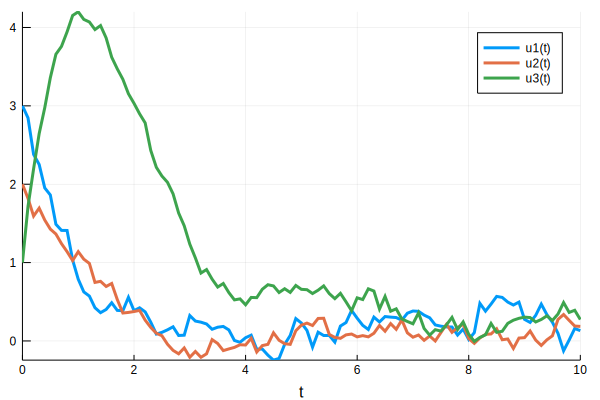

In [4]:
StochGeneReg = function(params::AbstractArray{Float64,1},
    Tspan::Tuple{Float64,Float64}, x0::AbstractArray{Float64,1},
    solver::StochasticDiffEq.StochasticDiffEqAlgorithm, dt::Float64)

  if size(params,1) != 10
    throw(ArgumentError("GeneReg needs 10 parameters, $(size(params,1)) were provided"))
  end
    
  function sigma_3GeneReg(dx, x, par, t)
    dx[1] = 0.3
    dx[2] = 0.3
    dx[3] = 0.3
  end

  function ODE_3GeneReg(dx, x, par, t)
    dx[1:3] = S*reaction_rate_function(x, par)
  end

  prob = SDEProblem(ODE_3GeneReg, sigma_3GeneReg, x0 ,Tspan, params)
  Obs = solve(prob, solver, dt=dt)

  return Obs
end

Tspan = (0., 10.) #timspan
x0 = [3.0, 2.0, 1.0] #initial conditions
solver = EM()
dt = 0.1

SDE_solution = StochGeneReg(params, Tspan, x0, solver, saveat)

plot(SDE_solution)

## Computing the LNA

Now if the user wishes to do the LNA of the above stochastic problem the process simply begins by setting up an LNAInput structure:

In [ ]:
volume = 100.0
input = LNAInput(params, S, reaction_rate_function, volume)

GpABC.LNAInput([2.0, 1.0, 15.0, 1.0, 1.0, 1.0, 100.0, 1.0, 1.0, 1.0], [1.0 -1.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 1.0 -1.0], #1, 100.0)

Now if the user wishes to see the results from the two ODEs:
    
$$
\begin{align}
\frac{d\varphi}{dt}&=\mathcal{S}\textbf{f}(\boldsymbol\varphi) \label{mean} \\ 
\frac{d\Sigma}{dt}&=\mathcal{A} \, \Sigma + \Sigma \, \mathcal{A}^T + \frac{1}{\sqrt{\Omega}} \, \mathcal{S} \, \text{diag}(\textbf{f}(\boldsymbol\varphi)) \, \mathcal{S}^T \label{covar}
\end{align}
$$

The user must simply provide the initial condtions in the form of (initial conditions of the species, initial covariance) and then call `compute_LNA`. 

This returns a `LNA` structure which holds the solutions to the above ODEs. The means, $\varphi$ can be called by `lna.traj_means` and the covariance $\Sigma$ can be called by `lna.traj_covars`. The time points the system of ODEs were solved for can be called by `lna.time_points`. 

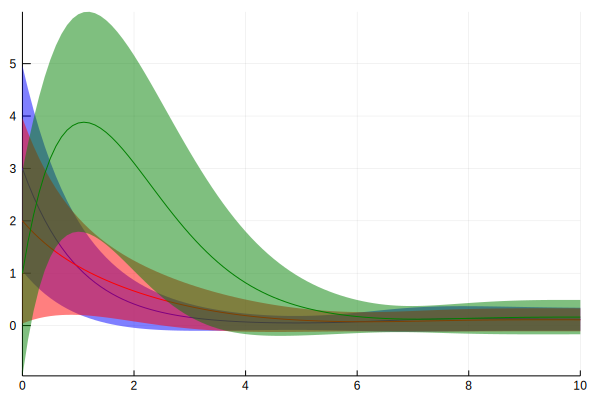

In [6]:
x0 = ([3.0, 2.0, 1.0], eye(3)) #initial conditions
solver = RK4()
saveat = 0.1

lna = compute_LNA(input, x0, Tspan, saveat)

covariance = lna.traj_covars
t = lna.time_points
mean  = lna.traj_means


variance = zeros(size(S)[1], length(t))
for (idx, elt) in enumerate(covariance)
    variance[:, idx] = diag(elt)
end

plot(t, mean[1,:], ribbon=1.96*sqrt.(variance[1,:]), c=:blue, leg=false)
plot!(t, mean[2,:], ribbon=1.96*sqrt.(variance[2,:]), c=:red, leg=false)
plot!(t, mean[3,:], ribbon=1.96*sqrt.(variance[3,:]), c=:green, leg=false)

The three means are plotted with the shaded areas being the 95% confidence intervals.

## Sampling from the LNA

The LNA gives the mean of the tracjectories and the covariance between them; hence a single trajectory can be sampled from a Multivariate Normal distribution. The function `sample_LNA_trajectories` automatically does this. 

The user can also sample more than one trajectory, which are then averaged, by changing `n_samples`. The effect of varying `n_samples` is shown below:

  0.672119 seconds (296.26 k allocations: 14.979 MiB, 1.69% gc time)


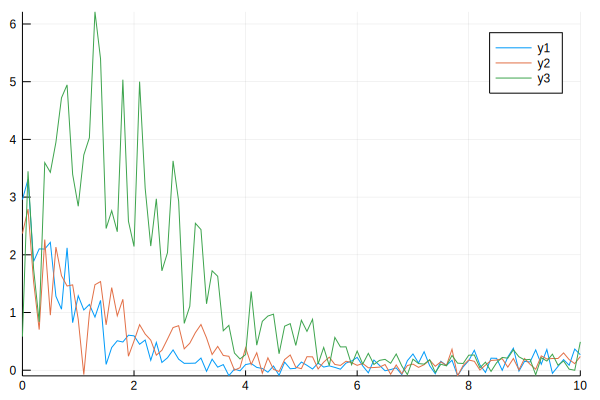

In [7]:
n_samples = 1

@time lna_trajectories = sample_LNA_trajectories(lna, n_samples)

plot(t, lna_trajectories[1,:])
plot!(t, lna_trajectories[2,:])
plot!(t, lna_trajectories[3,:])

  0.000359 seconds (2.24 k allocations: 134.125 KiB)


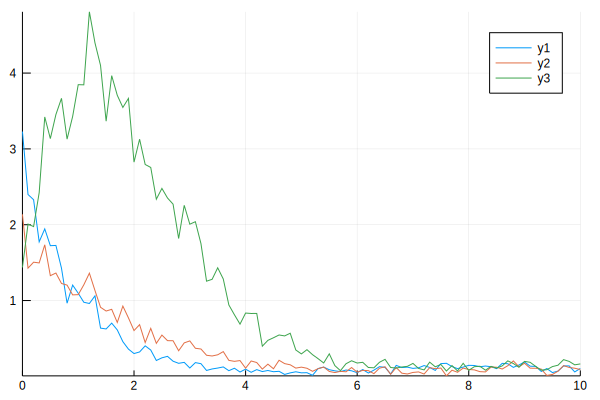

In [ ]:
n_samples = 10

@time lna_trajectories = sample_LNA_trajectories(lna, n_samples)

plot(t, lna_trajectories[1,:])
plot!(t, lna_trajectories[2,:])
plot!(t, lna_trajectories[3,:])

  0.000922 seconds (2.24 k allocations: 353.484 KiB)


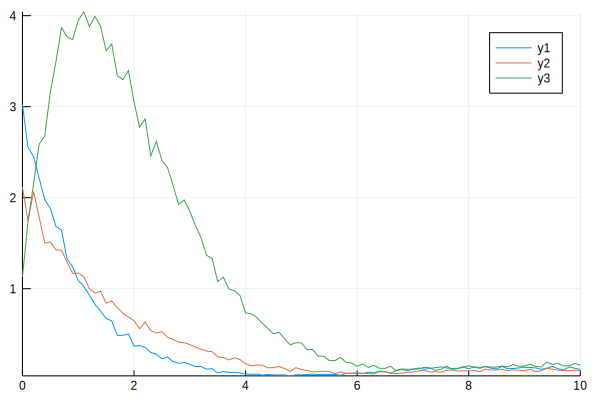

In [ ]:
n_samples = 100

@time lna_trajectories = sample_LNA_trajectories(lna, n_samples)

plot(t, lna_trajectories[1,:])
plot!(t, lna_trajectories[2,:])
plot!(t, lna_trajectories[3,:])

## ABC using the LNA


Now the notebook will run through the same examples located in `abc-examples.ipynb` but using the LNA. Let's try and estimate the first three parameters, comparing simulation based ABC and emulation based ABC.

### Simulation-Based Rejection ABC

In [ ]:
function simulator_function(var_params)
    input = LNAInput(vcat(var_params, params[n_var_params+1:end]), S, reaction_rate_function, volume)
    return get_LNA_trajectories(input, n_samples, x0, Tspan, saveat)
end

simulator_function (generic function with 1 method)

GpABC rejection simulation 2018-10-24T15:30:12.035 ϵ = 2.0.
GpABC rejection simulation 2018-10-24T15:30:21.557 Accepted 48/1000 particles.
GpABC rejection simulation 2018-10-24T15:30:30.456 Accepted 106/2000 particles.
GpABC rejection simulation 2018-10-24T15:30:39.342 Accepted 171/3000 particles.
GpABC rejection simulation 2018-10-24T15:30:48.242 Accepted 226/4000 particles.
GpABC rejection simulation 2018-10-24T15:30:57.146 Accepted 278/5000 particles.


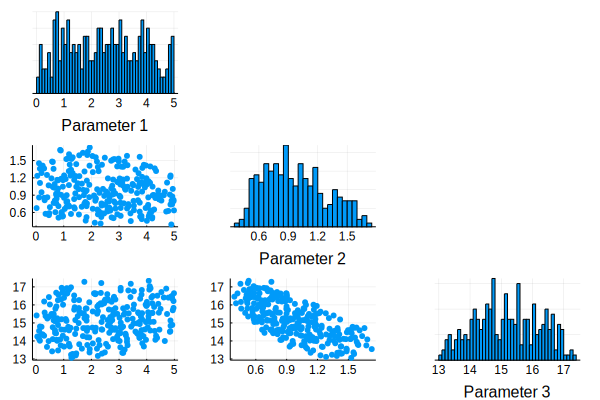

In [11]:
priors = [Uniform(0., 5.), Uniform(0., 5.), Uniform(10., 20.)]
n_var_params = length(priors)
n_particles = 500
threshold = 2.0
progress_every = 100
reference_data = lna_trajectories

sim_result = SimulatedABCRejection(reference_data,
                        simulator_function,
                        priors,
                        threshold,
                        n_particles
                        )

plot(sim_result)

### Emulation-Based Rejection ABC

GpABC rejection emulation 2018-10-24T15:31:02.244 ϵ = 2.0.
GpABC rejection emulation 2018-10-24T15:31:14.311 accepted 282/5000 particles (1 batches of size 5000).
GpABC rejection emulation 2018-10-24T15:31:14.415 accepted 500/10000 particles (2 batches of size 5000).


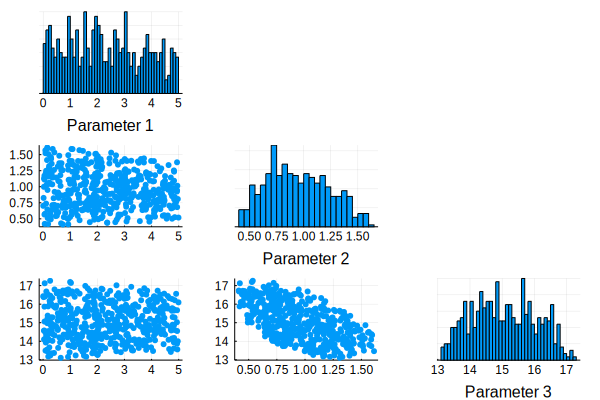

In [12]:
n_design_points = 200

emu_result = EmulatedABCRejection(reference_data,
                        simulator_function,
                        priors,
                        threshold,
                        n_particles,
                        n_design_points)


plot(emu_result)

### Simulation-Based ABC-SMC

GpABC rejection simulation 2018-10-24T15:31:15.547 ϵ = 4.0.
GpABC rejection simulation 2018-10-24T15:31:24.586 Accepted 305/1000 particles.
GpABC SMC Simulation 2018-10-24T15:31:30.691 ϵ = 3.0.
GpABC SMC Simulation 2018-10-24T15:31:43.337 Accepted 377/1000 particles.
GpABC SMC Simulation 2018-10-24T15:31:46.621 Finished. Accepted 500/500.
GpABC SMC Simulation 2018-10-24T15:31:46.638 ϵ = 2.0.
GpABC SMC Simulation 2018-10-24T15:31:57.099 Accepted 212/1000 particles.
GpABC SMC Simulation 2018-10-24T15:32:07.653 Accepted 400/2000 particles.
GpABC SMC Simulation 2018-10-24T15:32:12.541 Finished. Accepted 500/500.


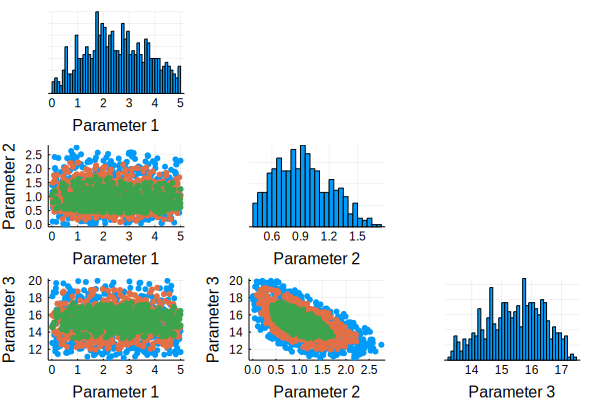

In [13]:
threshold_schedule = [4.0, 3.0, 2.0]

sim_abcsmc_res = SimulatedABCSMC(reference_data,
                        simulator_function,
                        priors,
                        threshold_schedule,
                        n_particles)
plot(sim_abcsmc_res)

### Emulation-Based ABC-SMC

GpABC rejection emulation 2018-10-24T15:32:13.699 ϵ = 4.0.
GpABC rejection emulation 2018-10-24T15:32:16.171 accepted 500/5000 particles (1 batches of size 5000).
GpABC SMC Emulation 2018-10-24T15:32:16.374 ϵ = 3.0.
GpABC SMC Emulation 2018-10-24T15:32:21.166 Accepted 500/5000 particles.
GpABC SMC Emulation 2018-10-24T15:32:21.194 ϵ = 2.0.
GpABC SMC Emulation 2018-10-24T15:32:25.68 Accepted 500/5000 particles.


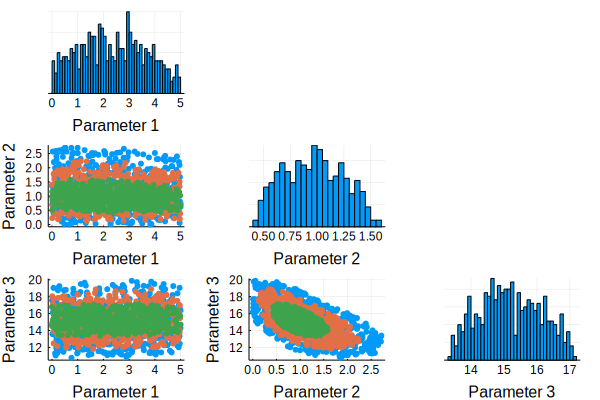

In [14]:
threshold_schedule = [4.0, 3.0, 2.0]

emu_abcsmc_res = EmulatedABCSMC(reference_data,
                        simulator_function,
                        priors,
                        threshold_schedule,
                        n_particles,
                        n_design_points)

plot(emu_abcsmc_res)